# Text sum using gensim

In [1]:
# genral imports
import gensim
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt')
from google.colab import files

# atalaia import
# clone package repository
!git clone https://github.com/vallantin/atalaia.git

# navigate to atalaia directory
%cd atalaia

# install packages requirements
!pip install -r requirements.txt

# install package
!python setup.py install

# import it
from atalaia.atalaia import Atalaia
from atalaia.explore import Explore
from atalaia.files import get_corpus, save_file

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Cloning into 'atalaia'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 116 (delta 72), reused 82 (delta 38), pack-reused 0
Receiving objects: 100% (116/116), 44.49 KiB | 8.90 MiB/s, done.
Resolving deltas: 100% (72/72), done.
/content/atalaia
     |████████████████████████████████| 51kB 3.5MB/s 
  Created wheel for emoji: filename=emoji-0.5.4-cp36-none-any.whl size=42176 sha256=843eaf35ea9211f72ab9279afc2b8b28bcf3e0ffe76e35b3ea95290ab39eb5e0
  Stored in directory: /root/.cache/pip/wheels/2a/a9/0a/4f8e8cce8074232aba240caca3fade315bb49fac68808d1a9c
Successfully built emoji
running install
running bdist_egg
running egg_info
creating Atalaia.egg-info
writing Atalaia.egg-info/PKG-INFO
writing dependency_links to Atalaia.egg-info/dependency_links.txt
writing top-level names to Atalai

Load file.

In [2]:
# define language
lg = 'en'

# start aruana
#aruana  = Aruana(lg)
atalaia = Atalaia(lg)

# load corpus
corpus = files.upload()
path="restaurants.txt"
corpus = get_corpus(path, ispandas=False)

# replace newlines
corpus = [atalaia.replace_newline(sentence) for sentence in corpus] 

# keep unique
corpus

Saving restaurants.txt to restaurants.txt


['Coronavirus. . Our Ghost-Kitchen Future. . By Anna Wiener. . June 28, 2020. . A parking lot with trailer restaurants. . A business model that seemed marginal before the coronavirus pandemic now looks like the future of restaurants.Illustration James Clapham. . Last fall, walking down Mission Street, in San Francisco, I noticed a new addition to an otherwise unremarkable parking lot at the base of Bernal Heights Hill: a large, white trailer, about the size of three parking spaces, plastered with a banner that read “food pick up here.” On one side was a list of restaurant brands with names and logos that seemed algorithmically generated: WokTalk, Burger Bytes, Fork and Ladle, Umami, American Eclectic Burger, Wings & Things. The trailer was hooked up to a generator, which was positioned behind two portable toilets; it occupied parking spots once reserved for Maven, an hourly-car-rental startup, funded by General Motors and marketed to gig-economy workers. (G.M. shut down Maven in April.

Despite being a good way to get smaller sentences from a paragraph, NLTK sentence tokenizer is not always very precise.

In [3]:
# tokenize and get sentences
sentences = [sentence for text in corpus for sentence in sent_tokenize(str(text)) if sentence != '.' and sentence !=''] # flatten list
sentences[:5]

['Coronavirus.',
 'Our Ghost-Kitchen Future.',
 'By Anna Wiener.',
 'June 28, 2020. .',
 'A parking lot with trailer restaurants.']

## Explore

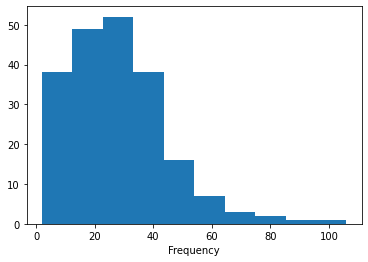

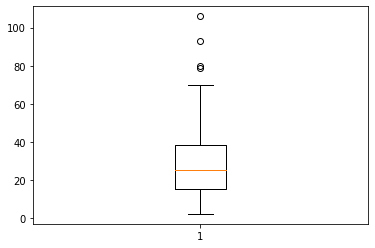

Shortest sentence has length of: 2.0.
Longest sentence has length of:  106.0.
Average sentence has length of:  25.
Percentiles: (2.0, 15.0, 25.0, 38.0, 106.0).


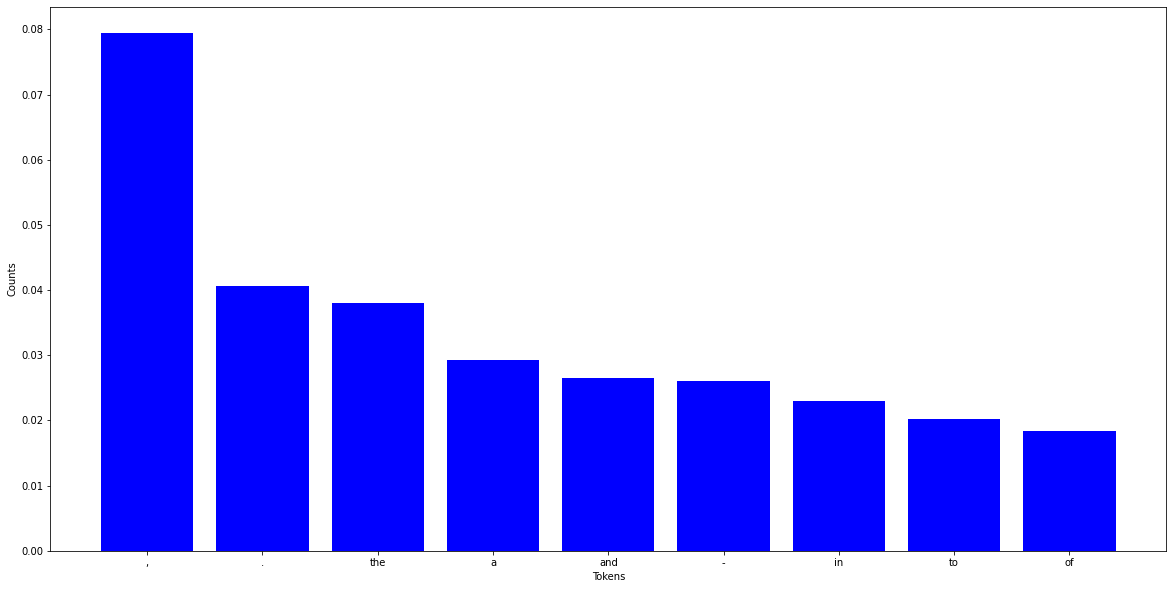

In [4]:
# Start Explore
explore = Explore(lg)

# plot histogram
sentences_sizes, shortest, longest, average, percentiles = explore.plot_sentences_size_histogram(sentences, bins=10)

# plot boxplot
explore.plot_sentences_size_boxplot(sentences)

# plot most representative words
explore.plot_representative_tokens(sentences)

print('Shortest sentence has length of: {}.'.format(shortest))
print('Longest sentence has length of:  {}.'.format(longest))
print('Average sentence has length of:  {}.'.format(int(average)))
print('Percentiles: {}.'.format(str(percentiles)))

We have a corpus with an average sentence size of 25 tokens and a few outlier sentences. 

Let's remove the sentences that are to short and the ones that are too long.

In [5]:
# exclude short sentences
# get sentences longer than 80% of the average size
# include a maxcap to avoid outliers
min_cap   = int(average - (average*0.2))
max_cap   = 70
sentences = [sentence.strip() for sentence in sentences if len(atalaia.tokenize(sentence)) > min_cap and len(atalaia.tokenize(sentence)) < max_cap]

# keep unique
sentences = list(set(sentences))

# clean the sentences
clean_sentences = atalaia.preprocess_list(sentences,
                                          tokenize=False, 
                                          stem=True, 
                                          remove_stopwords=True, 
                                          remove_numbers=True, 
                                          remove_punct=True,
                                          strip_accs=True)

clean_sentences[:5]

['consolid local commerc servic privat ventur fund compani without communiti histori commit carri obvious risk',
 'virtual restaur brand often eye catch pun soak name seem rip short stori lorri moor a la couch endless pastabl mac futur bad mutha clucka',
 'due coronavirus pandem version long term futur reef anticip diminish automobil usag hyper local unexpect materi',
 'start compani miami name parkjockey initi offer app reserv park space advanc launch follow year london chicago',
 'chuck e chees famili restaur chain site arcad friend rat mascot recent launch virtual restaur brand pasqual pizza & wing reach broader custom base pandem']

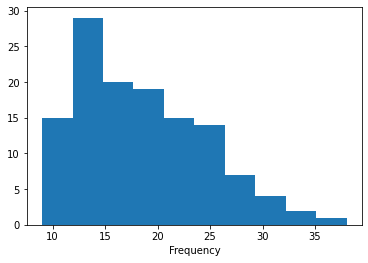

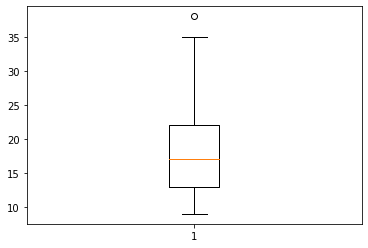

Shortest sentence has length of: 9.0.
Longest sentence has length of:  38.0.
Average sentence has length of:  17.
Percentiles: (9.0, 13.0, 17.0, 22.0, 38.0).


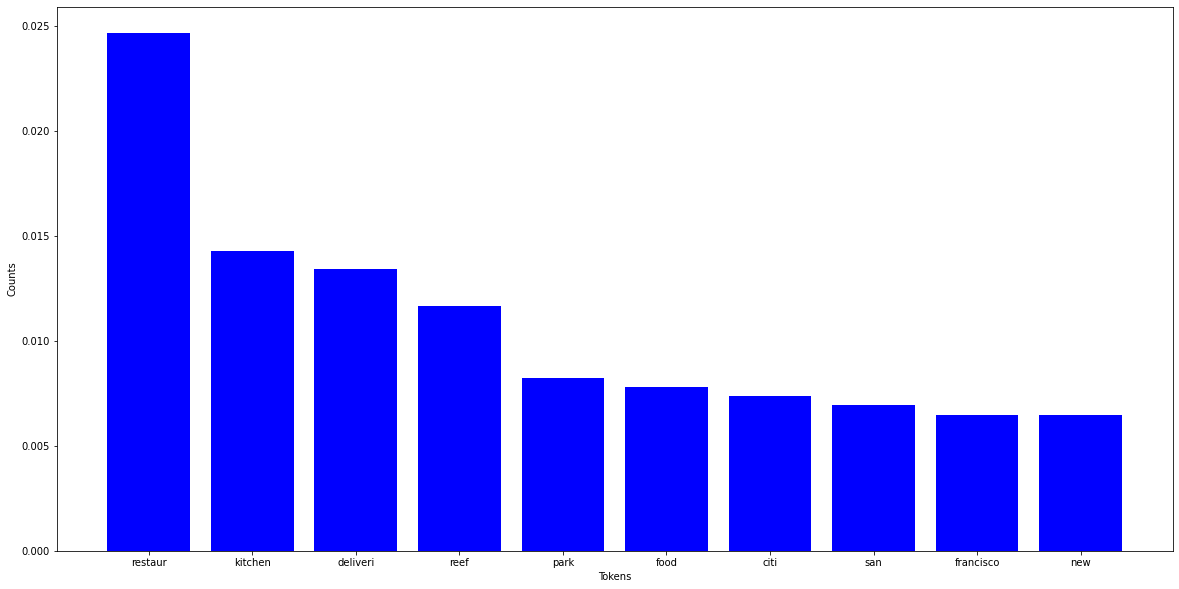

In [6]:
# plot histogram
sentences_sizes, shortest, longest, average, percentiles = explore.plot_sentences_size_histogram(clean_sentences, bins=10)

# plot boxplot
explore.plot_sentences_size_boxplot(clean_sentences)

# plot most representative words
explore.plot_representative_tokens(clean_sentences)

print('Shortest sentence has length of: {}.'.format(shortest))
print('Longest sentence has length of:  {}.'.format(longest))
print('Average sentence has length of:  {}.'.format(int(average)))
print('Percentiles: {}.'.format(str(percentiles)))

After replotting, we see that  we have a few less outliers and that sentences such as the article date, written by...etc just disappeared. Now, we can see that words like "restaurant" and "delivery" are understood as being important on this corpus.

We now can use Gensim to summarize it.

Gensim's summarizer receives as input a corpus on a string format. Documentation says that newlines are used to indicate sentences' boundaries. 

Our processed corpus has no punctuation, so we need a way to mark the ends of our sentences when we transform it into a long textual blob.

In [7]:
# add a newline to the end of the processed sentences
clean_sentences_punct = [s + '\n' for s in clean_sentences]
clean_sentences_punct[:5]

['consolid local commerc servic privat ventur fund compani without communiti histori commit carri obvious risk\n',
 'virtual restaur brand often eye catch pun soak name seem rip short stori lorri moor a la couch endless pastabl mac futur bad mutha clucka\n',
 'due coronavirus pandem version long term futur reef anticip diminish automobil usag hyper local unexpect materi\n',
 'start compani miami name parkjockey initi offer app reserv park space advanc launch follow year london chicago\n',
 'chuck e chees famili restaur chain site arcad friend rat mascot recent launch virtual restaur brand pasqual pizza & wing reach broader custom base pandem\n']

Now, we create a dictionary that will retain the relation "processed: original" sentence. We will need a way, later, to map the processed sentences chosen by Gensim to the original ones. 

In [8]:
# create a dict to hold the processed and the original sentences
processed_original_sentences = dict(zip(clean_sentences_punct, sentences))

In [9]:
# transform into full text
text = atalaia.create_corpus(processed_original_sentences.keys())
# get summary using gensim
gensim_summary = gensim.summarization.summarize(text, ratio=0.1, split=True)
gensim_summary[:5]

['dougla upscal corner store cafe san francisco noe valley neighborhood emerg sort pickup window hand higher end restaur offer meal kit prepackag food homegrown variat reef central vision shop broker rather ventur fund startup',
 'februari new york citi council held oversight hear impact ghost kitchen local busi matt newberg entrepreneur independ journalist testifi visit cloudkitchen commissari los angel twenti seven kitchen occupi eleven thousand squar feet oper hundr fifteen restaur deliveri platform',
 'cloudkitchen new ventur run travi kalanick citi storag system buy real estat bring kitchen facil leas chef small busi owner whom not brick mortar space',
 'time restaur reli sort perform basic ghost kitchen model less exist decad deliber year domino oper kitchen takeout deliveri includ one street reef trailer mission well inadvert',
 'recent owner dosa fifteen year old upscal indian restaur locat oakland san francisco told eater plan move virtual model central commissari kitchen supp

I asked Gensim to output 10% of the most important sentences in a list format.  Now, I have to map these sentences to a format we can read.

In [10]:
# get original sentences
final_summary = [processed_original_sentences[s+'\n'] for s in gensim_summary]
final_summary[:5]

['Douglas, an upscale corner store and café in San Francisco’s Noe Valley neighborhood, has emerged as a sort of pickup window for a handful of higher-end restaurants, which offer meal kits and prepackaged food—a homegrown variation on Reef’s centralized vision, with the shop as a broker, rather than a venture-funded startup.',
 'In February, when the New York City Council held an oversight hearing on the impact of ghost kitchens on local businesses, Matt Newberg, an entrepreneur and independent journalist, testified that he had visited a CloudKitchens commissary in Los Angeles where twenty-seven kitchens, occupying eleven thousand square feet, operated a hundred and fifteen restaurants on delivery platforms.',
 'CloudKitchens, the new venture run by Travis Kalanick’s City Storage Systems, buys real estate, brings in kitchen facilities, and leases them to chefs and small-business owners, most of whom do not have other brick-and-mortar spaces.',
 'At the same time, most restaurants rely

This is the final text:

In [11]:
print('\n\n'.join(final_summary))

Douglas, an upscale corner store and café in San Francisco’s Noe Valley neighborhood, has emerged as a sort of pickup window for a handful of higher-end restaurants, which offer meal kits and prepackaged food—a homegrown variation on Reef’s centralized vision, with the shop as a broker, rather than a venture-funded startup.

In February, when the New York City Council held an oversight hearing on the impact of ghost kitchens on local businesses, Matt Newberg, an entrepreneur and independent journalist, testified that he had visited a CloudKitchens commissary in Los Angeles where twenty-seven kitchens, occupying eleven thousand square feet, operated a hundred and fifteen restaurants on delivery platforms.

CloudKitchens, the new venture run by Travis Kalanick’s City Storage Systems, buys real estate, brings in kitchen facilities, and leases them to chefs and small-business owners, most of whom do not have other brick-and-mortar spaces.

At the same time, most restaurants rely on a sort 

Curious to see the tokens considered as importants? Use the keywords method.

In [12]:
# print keywords
from gensim.summarization import keywords
print(keywords(text, ratio=0.01))

restaur
deliveri
kitchen
reef
citi
food
like
new
park space
